![Logo UOC](https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/logotips/logo-UOC-2linies.png)

# TFG - Inteligencia Artificial
Enero de 2026

## Predicción de Respuesta a Tratamientos Oncológicos Basada en el Perfil Genético Mediante Técnicas de Aprendizaje Automático (ML) e Identificación de Genes Candidatos a Biomarcador Usando Técnicas de Explicabilidad (XAI) y Cuantificación de la Incertidumbre (UQ)

---

#### Pablo Vázquez Rodríguez
##### Grado en Ingeniería Informática
##### Inteligencia Artificial

#### Dra. María Moreno de Castro
#### Dr. Friman Sánchez

---

## Modelado (Paso 3): Análisis de modelos y selección del modelo optimizado

Como ya se comentó en el documento de exploración y preparación de datos durante el modelado se harán dos tareas:
1. Selección de características supervisada
2. Entrenamiento de modelos, comparaciones y selección del modelo óptimo

Durante la primera tarea se realizó una selección de genes basada en modelos de regresión logística, Random Forest, XGBoost y CatBoost.

Durante la segunda tarea, se entrenarán los modelos de nuevo esta vez sobre el conjunto que contiene sólo a los genes seleccionados. Tras el entrenamiento se evaluarán para elegir el modelo óptimo, sobre el que más adelante se aplicarán técnicas de explicabilidad y cuantificación de la incertidumbre.

## 0. Operaciones previas

### Carga de módulos necesarios

In [106]:
import pandas as pd
import numpy as np
import optuna
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    f1_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

### Configuraciones iniciales

In [26]:
# Random generator de numpy con seed para reproducibilidad en el notebook
rng_seed = 19293
rng = np.random.default_rng(seed=rng_seed)

In [27]:
# Carga de los datasets
df_full = pd.read_csv("./data/final/full_top_significance_reduced_feat.csv")
df_train = pd.read_csv("./data/final/train_reduced_feat.csv")
df_test = pd.read_csv("./data/final/test_reduced_feat.csv")
df_cal = pd.read_csv("./data/final/cal_reduced_feat.csv")
df_scaled_train = pd.read_csv("./data/final/scaled_train_reduced_feat.csv")
df_scaled_test = pd.read_csv("./data/final/scaled_test_reduced_feat.csv")
df_scaled_cal = pd.read_csv("./data/final/scaled_cal_reduced_feat.csv")

In [28]:
# Carga de los estudios realizados
optuna_storage_path = "sqlite:///./data/optuna_studies/studies.db"

logreg_study_name = "2025-11-27T20:02:16.860770_best_logreg_model_study"
logreg_study = optuna.load_study(study_name=logreg_study_name, storage=optuna_storage_path)

rf_study_name = "2025-11-27T20:04:53.098487_best_rf_model_study"
rf_study = optuna.load_study(study_name=rf_study_name, storage=optuna_storage_path)

xgboost_study_name = "2025-11-27T20:23:32.991022_best_xgboost_model_study"
xgboost_study = optuna.load_study(study_name=xgboost_study_name, storage=optuna_storage_path)

catboost_study_name = "2025-11-27T20:28:54.108985_best_catboost_model_study"
catboost_study = optuna.load_study(study_name=catboost_study_name, storage=optuna_storage_path)

In [29]:
# Carga de los modelos entrenados
logreg_model = joblib.load("./data/best_models/best_logreg_model.joblib")
rf_model = joblib.load("./data/best_models/best_rf_model.joblib")
xgboost_model = joblib.load("./data/best_models/best_xgboost_model.joblib")
catboost_model = joblib.load("./data/best_models/best_catboost_model.joblib")

In [30]:
# VARIABLES ÚTILES

# Nombres de las columnas de genes
gene_columns = df_full.columns.difference(["Sample_id", "Response"])

In [93]:
# Datos de entrenamiento
X_train = df_scaled_train.drop(columns=["Response", "Sample_id"])
y_train_orig = df_scaled_train["Response"]

# Datos de test
X_test = df_scaled_test.drop(columns=["Response", "Sample_id"])
y_test_orig = df_scaled_test["Response"]

# Datos de calibración
X_cal = df_scaled_cal.drop(columns=["Response", "Sample_id"])
y_cal_orig = df_scaled_cal["Response"]

# Para simplificar el modelado con la función auxiliar, se decide en este punto
# transformar Response de Categórica a 0/1

# Clases objetivo a 0/1: Non_response=0, Response=1
le = LabelEncoder()
y_train = le.fit_transform(y_train_orig)
y_test = le.fit_transform(y_test_orig)
y_cal = le.fit_transform(y_cal_orig)

# Mostrar mapeo de clases
for i, label in enumerate(le.classes_): print(f"{i}: {label}")

### Análisis de modelos

---
**Regresión Logística**

**Valores obtenidos**

**Estudio**: 2025-11-27T20:02:16.860770_best_logreg_model_study

**Mejores parámetros**: {'C': 0.18060406163147527, 'l1_ratio': 0.3923023726101893} 

**Mejor F1-Score**: 0.6047920333207006

---
**Random Forest**

**Valores obtenidos**

**Estudio**: 2025-11-27T20:04:53.098487_best_rf_model_study

**Mejores parámetros**: {'n_estimators': 118, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2} 

**Mejor F1-Score**: 0.6563895319317158

---
**XGBoost**

**Valores obtenidos**

**Estudio**: 2025-11-27T20:23:32.991022_best_xgboost_model_study

**Mejores parámetros**: {'n_estimators': 664, 'max_depth': 7, 'learning_rate': 0.09355289686325986, 'min_child_weight': 5, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8972767907569935, 'colsample_bytree': 0.9031756022599345} 

**Mejor F1-Score**: 0.6600449930441188

---
**CatBoost**

**Valores obtenidos**

**Estudio**: 2025-11-27T20:28:54.108985_best_catboost_model_study

**Mejores parámetros**: {'iterations': 420, 'depth': 6, 'learning_rate': 0.1473969376583399, 'l2_leaf_reg': 3, 'rsm': 0.9182696747233586} 

**Mejor F1-Score**: 0.6579436065221502

---

## 1. Análisis

El análisis ha de cubrir:

1. Comparación de modelos contra el de regresión (linea base)
2. Comparación entre los demás modelos de cara a la elección (incluir mejor F1-Score con umbral auto)
3. Elegir el mejor, crear o mostrar su matriz de confusión tras optimizar el umbral

### 1.1 Contexto del dataset y objetivo

* Gráfico de Proporción de clases en el dataset

* Gráfico de métricas comparativo de los algoritmos (LogReg, RandomForest, XGBoost y CatBoost)

* Tabla de características más importantes de cada modelo (hiperparámetros de mayor importancia, valores de las métricas, umbral de decisión óptimo)

* Matriz de confusión del modelo optimizado seleccionado (con y sin aplicar el umbral de optimización)

En el siguiente gráfico se muestra la distribución de las clases Non_response y Response en cada conjunto de datos. El desbalance no es extremo (aproximadamente 66% frente a 33%), pero la clase Response es la prioritaria.

El objetivo es reducir los falsos negativos, es decir, evitar que un usuario que realmente respondería al tratamiento sea clasificado como Non_response.

Dado que la clase de interés es la minoritaria, no resulta adecuado evaluar únicamente con accuracy. Por ello se dará mayor relevancia a métricas que reflejan mejor el rendimiento sobre la clase positiva, como el F1-score, el ROC-AUC y la curva de Precision-Recall, optimizando además el umbral de decisión.

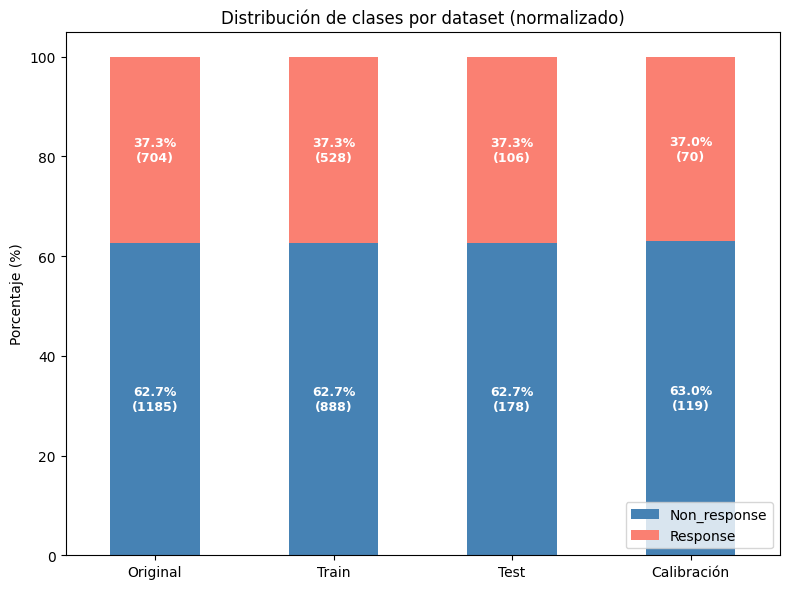

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# Construir tabla con los conteos
counts = pd.DataFrame({
    "Original": df_full["Response"].value_counts(),
    "Train": df_train["Response"].value_counts(),
    "Test": df_test["Response"].value_counts(),
    "Calibración": df_cal["Response"].value_counts()
})

# Transponer para que cada dataset sea una fila
counts = counts.T

# Normalizar a porcentajes
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Graficar como barras apiladas
ax = percentages.plot(kind="bar", stacked=True, color=["steelblue", "salmon"], figsize=(8,6))

# Añadir etiquetas con porcentaje y conteo
for i, dataset in enumerate(percentages.index):
    bottom = 0
    for clase in percentages.columns:
        pct = percentages.loc[dataset, clase]
        val = counts.loc[dataset, clase]
        ax.text(i, bottom + pct/2, f"{pct:.1f}%\n({val})",
                ha="center", va="center", fontsize=9, color="white", weight="bold")
        bottom += pct

ax.set_ylabel("Porcentaje (%)")
ax.set_title("Distribución de clases por dataset (normalizado)")
ax.legend(loc="lower right")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### 1.2 Evaluación de modelos

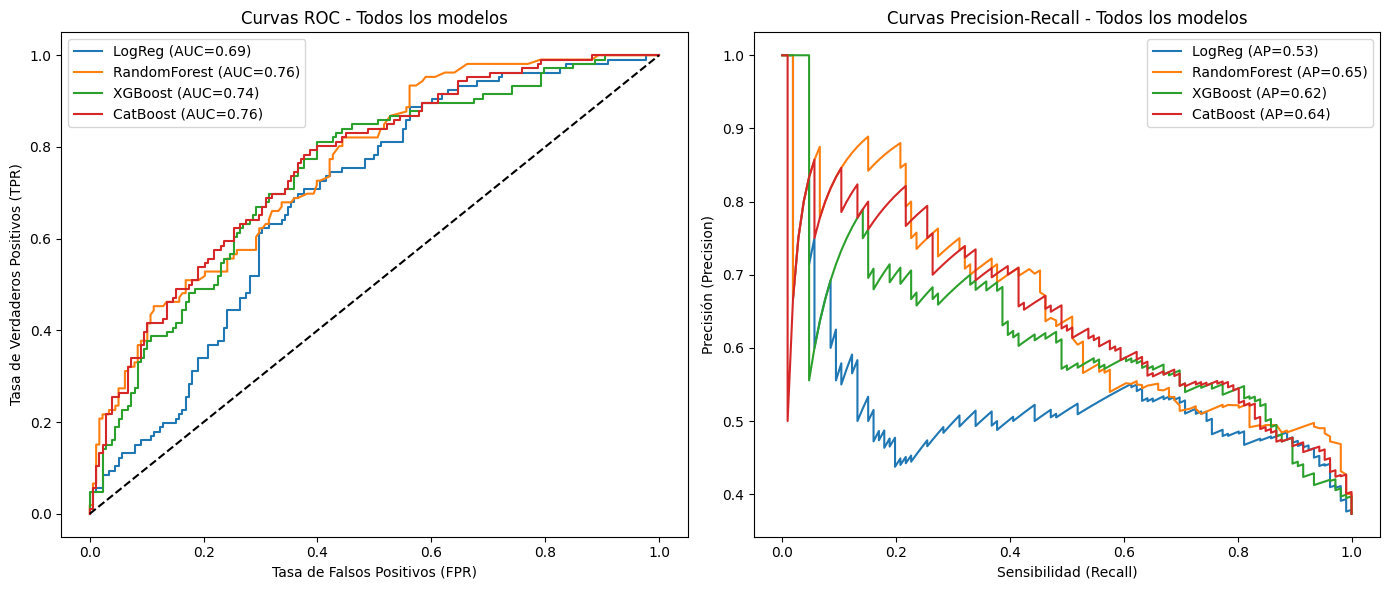

In [126]:
# Gráficos ROC y Precision-Recall de todos los modelos
fig, ax = plt.subplots(1,2, figsize=(14,6))

# ROC
for name, y_score in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
ax[0].plot([0,1],[0,1],'k--')
ax[0].set_xlabel("Tasa de Falsos Positivos (FPR)")
ax[0].set_ylabel("Tasa de Verdaderos Positivos (TPR)")
ax[0].set_title("Curvas ROC - Todos los modelos")
ax[0].legend()

# Precission-Recall
for name, y_score in probas.items():
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    ap = average_precision_score(y_test, y_score)
    ax[1].plot(recall, precision, label=f"{name} (AP={ap:.2f})")
ax[1].set_xlabel("Sensibilidad (Recall)")
ax[1].set_ylabel("Precisión (Precision)")
ax[1].set_title("Curvas Precision-Recall - Todos los modelos")
ax[1].legend()

plt.tight_layout()
plt.show()

In [146]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, precision_recall_curve
)

results = []

for name, y_score in probas.items():
    # Predicciones con umbral 0.5
    y_pred = (y_score >= 0.5).astype(int)
    
    # Métricas básicas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC-AUC (ya lo calculabas para el gráfico)
    roc_auc = roc_auc_score(y_test, y_score)
    
    # Average Precision (AP) (ya lo calculabas para el gráfico)
    ap = average_precision_score(y_test, y_score)
    
    # Umbral óptimo de F1 (reaprovechando precision_recall_curve)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_score)
    f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-10)
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    best_f1 = f1_scores[best_idx]
    
    results.append({
        "Modelo": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 (0.5)": f1,
        "F1 óptimo": best_f1,
        "Umbral(max F1)": best_threshold,
        "ROC-AUC": roc_auc,
        "AP": ap
    })

# Convertir a DataFrame y mostrar
df_results = pd.DataFrame(results)
format_dict = {col: "{:.2f}" for col in df_results.columns if col != "Modelo"}
def highlight_max_f1(row):
    if row['Modelo'] == "CatBoost":
        return ['background-color: #ccffcc'] * len(row)
    else:
        return [''] * len(row)
df_results.style.format(format_dict).apply(highlight_max_f1, axis=1)


,Modelo,Accuracy,Precision,Recall,F1 (0.5),F1 óptimo,Umbral(max F1),ROC-AUC,AP
0,LogReg,0.66,0.53,0.70,0.60,0.63,0.41,0.69,0.53
1,RandomForest,0.71,0.67,0.46,0.55,0.65,0.28,0.76,0.65
2,XGBoost,0.69,0.58,0.59,0.59,0.65,0.20,0.74,0.62
3,CatBoost,0.70,0.60,0.58,0.59,0.65,0.19,0.76,0.64


En la comparación de modelos:

* **Logistic Regression** ofrece mayor sensibilidad pero baja discriminación global
* **RandomForest** mejora métricas agregadas pero pierde demasiados respondedores
* **XGBoost** logra un perfil equilibrado y clínicamente aceptable
* **CatBoost** combina buen recall con mejores métricas globales, consolidándose como la opción más robusta.

Se recomienda CatBoost como modelo de referencia, al lograr un balance adecuado entre detección de respondedores y rendimiento global.

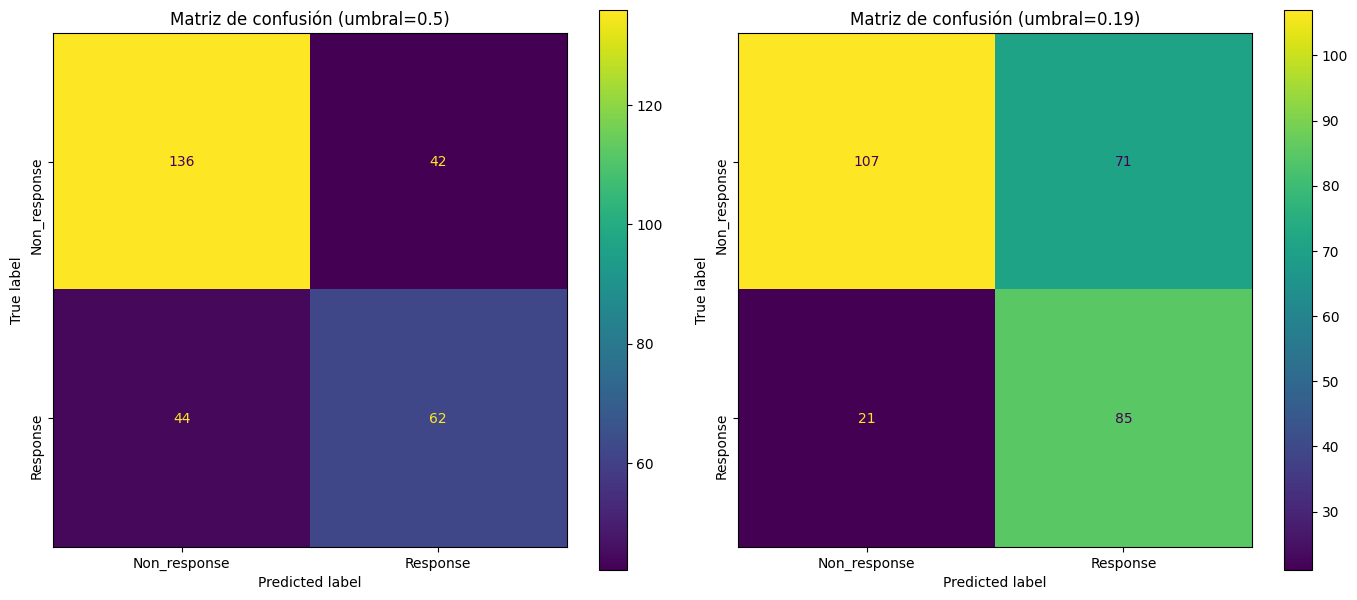

In [158]:
# Matriz de confusión antes y después de optimizar el umbral
y_pred_default = (y_score >= 0.5).astype(int)
y_pred_opt = (y_score >= best_threshold).astype(int)

# Crear un gráfico múltiple de 1x2
fig, ax = plt.subplots(1,2, figsize=(14,6))

# Primer gráfico: Matriz de confusión con umbral base
cm_base = confusion_matrix(y_test, y_pred_default)
ConfusionMatrixDisplay(cm_base, display_labels=le.classes_).plot(ax=ax[0])
ax[0].set_title("Matriz de confusión (umbral=0.5)")

# Segundo gráfico: Matriz de confusión con umbral optimizado
cm_optimized = confusion_matrix(y_test, y_pred_opt)
ConfusionMatrixDisplay(cm_optimized, display_labels=le.classes_).plot(ax=ax[1])
ax[1].set_title(f"Matriz de confusión (umbral={best_threshold:.2f})")

# Rotar etiquetas eje y
for a in ax:
    for label in a.get_yticklabels():
        label.set_rotation(90)

plt.tight_layout()
plt.show()

La matriz de confusión muestra los trasvases entre antes y después de optimizar el umbral. Gracias a esa optimización se minimizan los falsos negativos sin cambiar el nivel predictivo global del modelo.